In [1]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 54.2 MB/s eta 0:00:00


In [2]:
!pip install transformers

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from torchmetrics.functional.classification import accuracy, auroc, f1_score
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

sns.set(style='whitegrid',palette='muted',font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### Training data

In [4]:
df_train = pd.read_json('train.json')
df_train.head()

,id,text,labels,link
0,65635,THIS IS WHY YOU NEED\n\nA SHARPIE WITH YOU AT ...,[Black-and-white Fallacy/Dictatorship],https://www.facebook.com/photo/?fbid=402355213...
1,67927,GOOD NEWS!\n\nNAZANIN ZAGHARI-RATCLIFFE AND AN...,"[Loaded Language, Glittering generalities (Vir...",https://www.facebook.com/amnesty/photos/531198...
2,68031,PAING PHYO MIN IS FREE!,[],https://www.facebook.com/amnesty/photos/427419...
3,77490,Move your ships away!\n\noooook\n\nMove your s...,[],https://www.facebook.com/rightpatriots/photos/...
4,67641,"WHEN YOU'RE THE FBI, THEY LET YOU DO IT.",[Thought-terminating cliché],https://www.facebook.com/AddictingInfoOrg/phot...


In [5]:
df_train.shape

(7000, 4)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7000 non-null   int64 
 1   text    7000 non-null   object
 2   labels  7000 non-null   object
 3   link    7000 non-null   object
dtypes: int64(1), object(3)
memory usage: 218.9+ KB


In [7]:
labels_train = df_train['labels']
labels_train

0                  [Black-and-white Fallacy/Dictatorship]
1       [Loaded Language, Glittering generalities (Vir...
2                                                      []
3                                                      []
4                            [Thought-terminating cliché]
                              ...                        
6995    [Loaded Language, Causal Oversimplification, T...
6996                      [Loaded Language, Whataboutism]
6997                                                   []
6998                                                   []
6999                                            [Slogans]
Name: labels, Length: 7000, dtype: object

In [8]:
CLASS_NAMES = set()

for category in labels_train:
    category = list(category)
    for label in category:
        CLASS_NAMES.add(label)

CLASS_NAMES

{'Appeal to authority',
 'Appeal to fear/prejudice',
 'Bandwagon',
 'Black-and-white Fallacy/Dictatorship',
 'Causal Oversimplification',
 'Doubt',
 'Exaggeration/Minimisation',
 'Flag-waving',
 'Glittering generalities (Virtue)',
 'Loaded Language',
 "Misrepresentation of Someone's Position (Straw Man)",
 'Name calling/Labeling',
 'Obfuscation, Intentional vagueness, Confusion',
 'Presenting Irrelevant Data (Red Herring)',
 'Reductio ad hitlerum',
 'Repetition',
 'Slogans',
 'Smears',
 'Thought-terminating cliché',
 'Whataboutism'}

In [9]:
len(CLASS_NAMES)

20

In [10]:
for label in CLASS_NAMES:
    df_train.insert(df_train.shape[1],label,[0] * df_train.shape[0],True)
df_train.shape

(7000, 24)

In [11]:
df_train.head()

,id,text,labels,link,Appeal to fear/prejudice,Black-and-white Fallacy/Dictatorship,Repetition,Thought-terminating cliché,Loaded Language,Presenting Irrelevant Data (Red Herring),...,Whataboutism,Smears,Reductio ad hitlerum,Doubt,Slogans,Misrepresentation of Someone's Position (Straw Man),Glittering generalities (Virtue),Causal Oversimplification,Flag-waving,Name calling/Labeling
0,65635,THIS IS WHY YOU NEED\n\nA SHARPIE WITH YOU AT ...,[Black-and-white Fallacy/Dictatorship],https://www.facebook.com/photo/?fbid=402355213...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,67927,GOOD NEWS!\n\nNAZANIN ZAGHARI-RATCLIFFE AND AN...,"[Loaded Language, Glittering generalities (Vir...",https://www.facebook.com/amnesty/photos/531198...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,68031,PAING PHYO MIN IS FREE!,[],https://www.facebook.com/amnesty/photos/427419...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,77490,Move your ships away!\n\noooook\n\nMove your s...,[],https://www.facebook.com/rightpatriots/photos/...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,67641,"WHEN YOU'RE THE FBI, THEY LET YOU DO IT.",[Thought-terminating cliché],https://www.facebook.com/AddictingInfoOrg/phot...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df_train.columns

Index(['id', 'text', 'labels', 'link', 'Appeal to fear/prejudice',
       'Black-and-white Fallacy/Dictatorship', 'Repetition',
       'Thought-terminating cliché', 'Loaded Language',
       'Presenting Irrelevant Data (Red Herring)', 'Exaggeration/Minimisation',
       'Appeal to authority', 'Bandwagon',
       'Obfuscation, Intentional vagueness, Confusion', 'Whataboutism',
       'Smears', 'Reductio ad hitlerum', 'Doubt', 'Slogans',
       'Misrepresentation of Someone's Position (Straw Man)',
       'Glittering generalities (Virtue)', 'Causal Oversimplification',
       'Flag-waving', 'Name calling/Labeling'],
      dtype='object')

In [13]:
for i in df_train.index:
    labels = list(df_train['labels'][i])
    for label in labels:
        df_train.at[i,label] = 1
df_train.head()

,id,text,labels,link,Appeal to fear/prejudice,Black-and-white Fallacy/Dictatorship,Repetition,Thought-terminating cliché,Loaded Language,Presenting Irrelevant Data (Red Herring),...,Whataboutism,Smears,Reductio ad hitlerum,Doubt,Slogans,Misrepresentation of Someone's Position (Straw Man),Glittering generalities (Virtue),Causal Oversimplification,Flag-waving,Name calling/Labeling
0,65635,THIS IS WHY YOU NEED\n\nA SHARPIE WITH YOU AT ...,[Black-and-white Fallacy/Dictatorship],https://www.facebook.com/photo/?fbid=402355213...,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,67927,GOOD NEWS!\n\nNAZANIN ZAGHARI-RATCLIFFE AND AN...,"[Loaded Language, Glittering generalities (Vir...",https://www.facebook.com/amnesty/photos/531198...,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,68031,PAING PHYO MIN IS FREE!,[],https://www.facebook.com/amnesty/photos/427419...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,77490,Move your ships away!\n\noooook\n\nMove your s...,[],https://www.facebook.com/rightpatriots/photos/...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,67641,"WHEN YOU'RE THE FBI, THEY LET YOU DO IT.",[Thought-terminating cliché],https://www.facebook.com/AddictingInfoOrg/phot...,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df_train['Doubt'].value_counts()

0    6650
1     350
Name: Doubt, dtype: int64

In [15]:
df_train.columns

Index(['id', 'text', 'labels', 'link', 'Appeal to fear/prejudice',
       'Black-and-white Fallacy/Dictatorship', 'Repetition',
       'Thought-terminating cliché', 'Loaded Language',
       'Presenting Irrelevant Data (Red Herring)', 'Exaggeration/Minimisation',
       'Appeal to authority', 'Bandwagon',
       'Obfuscation, Intentional vagueness, Confusion', 'Whataboutism',
       'Smears', 'Reductio ad hitlerum', 'Doubt', 'Slogans',
       'Misrepresentation of Someone's Position (Straw Man)',
       'Glittering generalities (Virtue)', 'Causal Oversimplification',
       'Flag-waving', 'Name calling/Labeling'],
      dtype='object')

In [16]:
column_names = df_train.columns[4:]
dictionary = {}

for label in column_names:
    dictionary[label] = [df_train[label].value_counts()[0], df_train[label].value_counts()[1]]

count_df = pd.DataFrame(dictionary)
count_df.head()

,Appeal to fear/prejudice,Black-and-white Fallacy/Dictatorship,Repetition,Thought-terminating cliché,Loaded Language,Presenting Irrelevant Data (Red Herring),Exaggeration/Minimisation,Appeal to authority,Bandwagon,"Obfuscation, Intentional vagueness, Confusion",Whataboutism,Smears,Reductio ad hitlerum,Doubt,Slogans,Misrepresentation of Someone's Position (Straw Man),Glittering generalities (Virtue),Causal Oversimplification,Flag-waving,Name calling/Labeling
0,6663,6220,6695,6472,5250,6941,6644,6150,6903,6979,6742,5010,6937,6650,6333,6938,6512,6760,6429,5482
1,337,780,305,528,1750,59,356,850,97,21,258,1990,63,350,667,62,488,240,571,1518


In [17]:
count_df.shape

(2, 20)

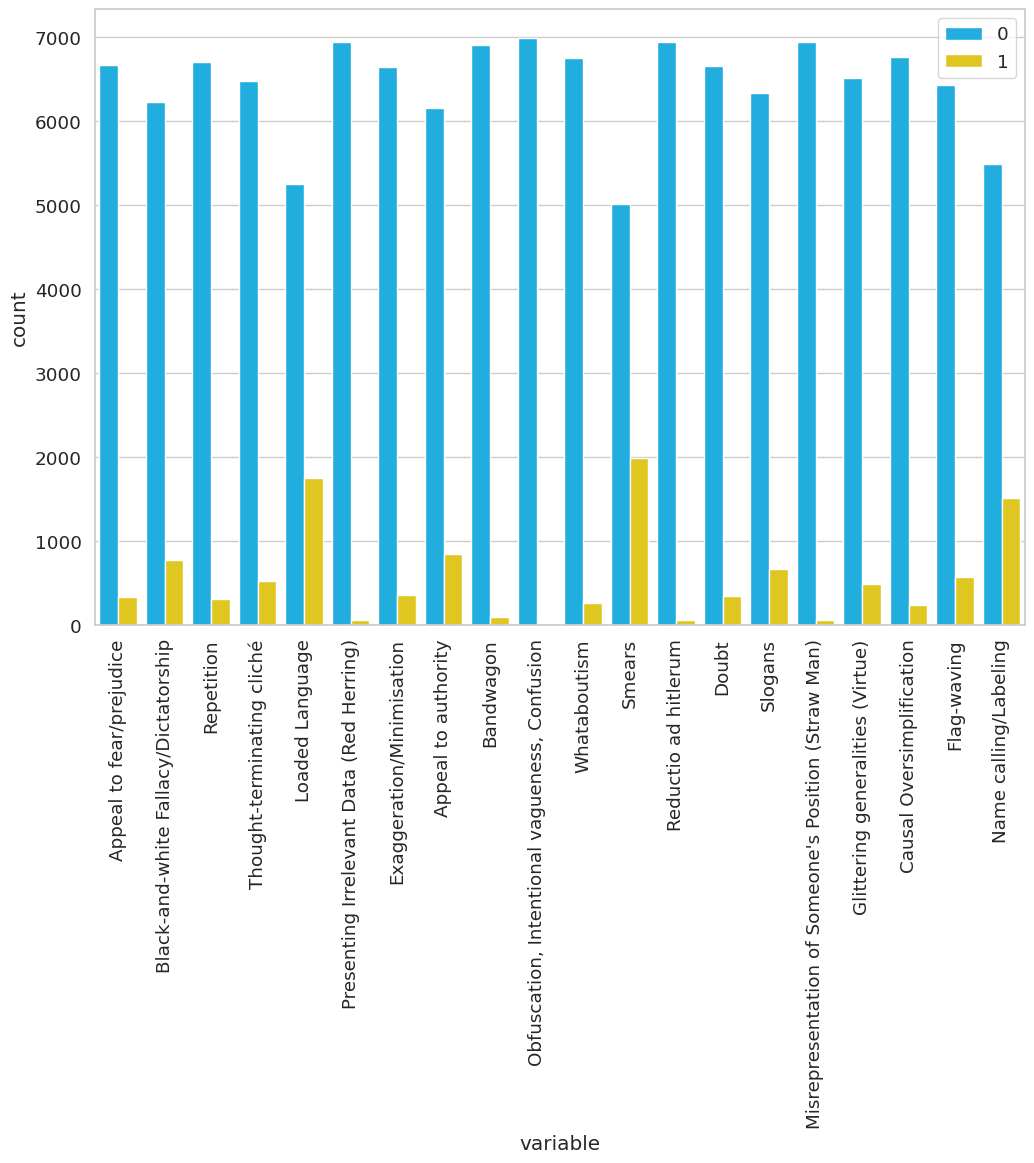

In [18]:
sns.countplot(data=df_train[column_names].melt(),x='variable',hue='value')
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=90);

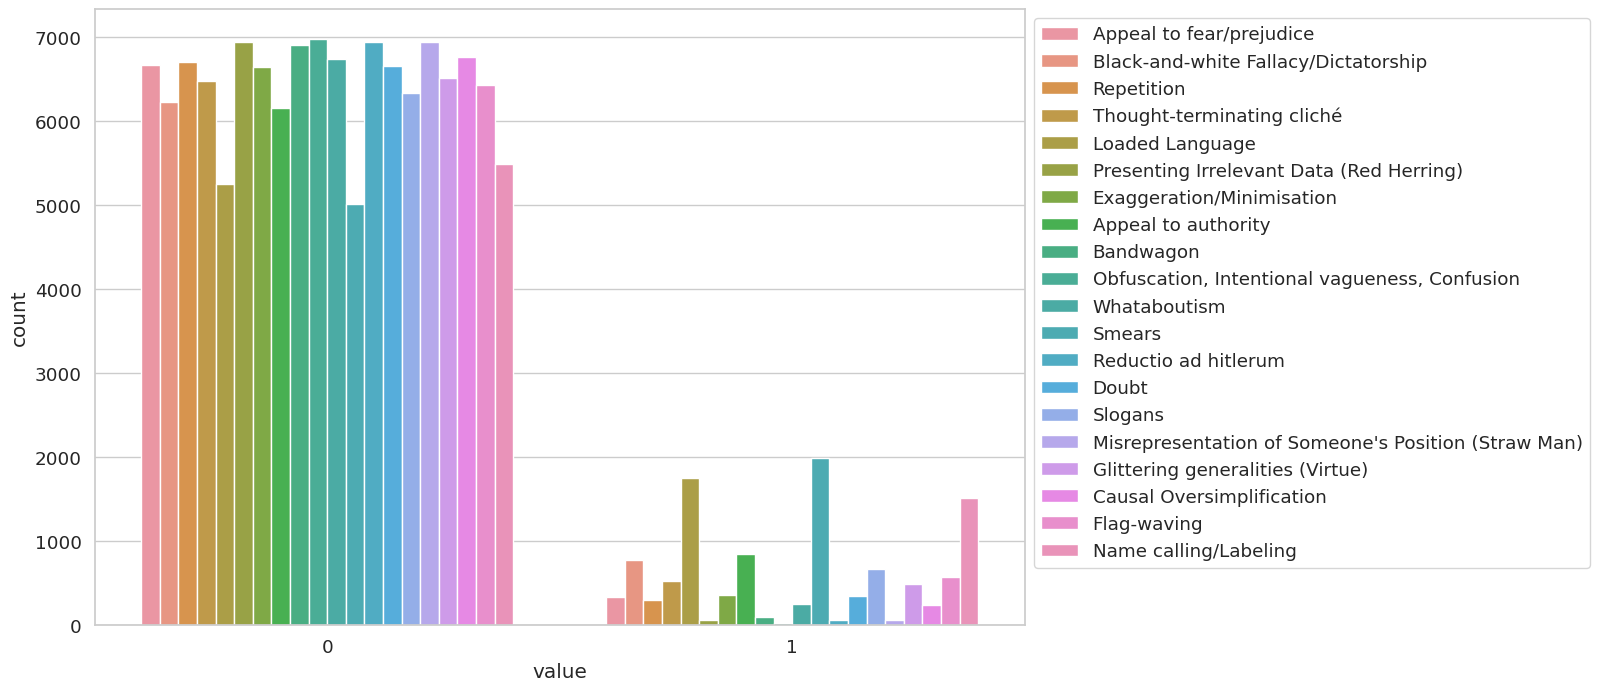

In [19]:
sns.countplot(data=df_train[column_names].melt(),x='value',hue='variable')
plt.legend(bbox_to_anchor=(1,1))

<Axes: >

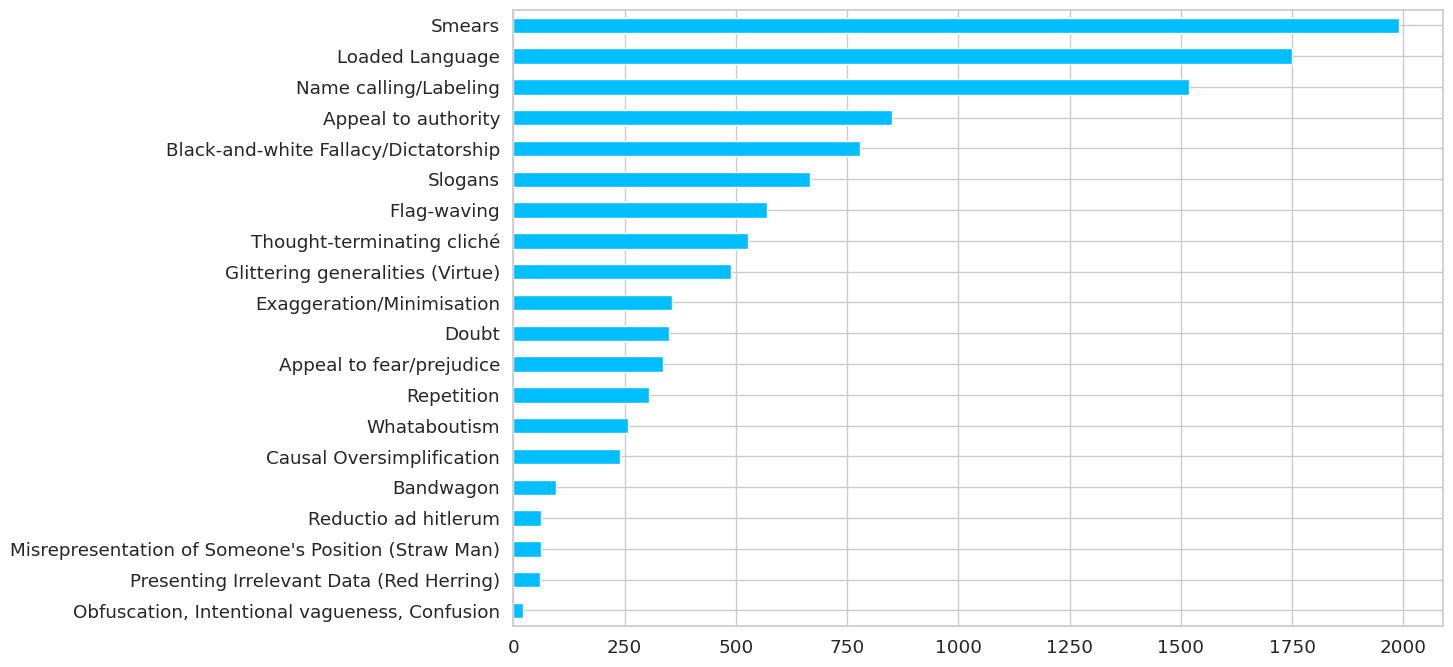

In [20]:
df_train[column_names].sum().sort_values().plot(kind='barh')

### Validation data

In [21]:
df_val = pd.read_json('validation.json')
df_val.head()

,id,text,labels,link
0,63135,Critical Thinking Essentials\n\Are my biases a...,"[Doubt, Slogans]",https://www.facebook.com/SkepticalMemeSociety/...
1,78590,Trying to think of a single accomplishment...,"[Exaggeration/Minimisation, Smears]",https://www.facebook.com/unitedstatesherald/ph...
2,65834,Corporate needs you to find the difference bet...,[Thought-terminating cliché],https://www.facebook.com/photo/?fbid=356249413...
3,67394,KYLE RITTENHOUSE\nALL CHARGES\nNOT GUILTY,[Glittering generalities (Virtue)],https://www.facebook.com/TheControversia/photo...
4,67709,Al Franken explains why America should tax the...,"[Appeal to authority, Slogans, Thought-termina...",https://www.facebook.com/AddictingInfoOrg/phot...


In [22]:
df_val.shape

(500, 4)

In [23]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      500 non-null    int64 
 1   text    500 non-null    object
 2   labels  500 non-null    object
 3   link    500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


In [24]:
labels_val = df_val['labels']
labels_val

0                                       [Doubt, Slogans]
1                    [Exaggeration/Minimisation, Smears]
2                           [Thought-terminating cliché]
3                     [Glittering generalities (Virtue)]
4      [Appeal to authority, Slogans, Thought-termina...
                             ...                        
495         [Slogans, Name calling/Labeling, Repetition]
496                                                   []
497                                                   []
498         [Causal Oversimplification, Loaded Language]
499    [Name calling/Labeling, Appeal to authority, B...
Name: labels, Length: 500, dtype: object

In [25]:
for label in CLASS_NAMES:
    df_val.insert(df_val.shape[1],label,[0] * df_val.shape[0],True)
df_val.shape

(500, 24)

In [26]:
df_val.head()

,id,text,labels,link,Appeal to fear/prejudice,Black-and-white Fallacy/Dictatorship,Repetition,Thought-terminating cliché,Loaded Language,Presenting Irrelevant Data (Red Herring),...,Whataboutism,Smears,Reductio ad hitlerum,Doubt,Slogans,Misrepresentation of Someone's Position (Straw Man),Glittering generalities (Virtue),Causal Oversimplification,Flag-waving,Name calling/Labeling
0,63135,Critical Thinking Essentials\n\Are my biases a...,"[Doubt, Slogans]",https://www.facebook.com/SkepticalMemeSociety/...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,78590,Trying to think of a single accomplishment...,"[Exaggeration/Minimisation, Smears]",https://www.facebook.com/unitedstatesherald/ph...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,65834,Corporate needs you to find the difference bet...,[Thought-terminating cliché],https://www.facebook.com/photo/?fbid=356249413...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,67394,KYLE RITTENHOUSE\nALL CHARGES\nNOT GUILTY,[Glittering generalities (Virtue)],https://www.facebook.com/TheControversia/photo...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,67709,Al Franken explains why America should tax the...,"[Appeal to authority, Slogans, Thought-termina...",https://www.facebook.com/AddictingInfoOrg/phot...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df_val.columns

Index(['id', 'text', 'labels', 'link', 'Appeal to fear/prejudice',
       'Black-and-white Fallacy/Dictatorship', 'Repetition',
       'Thought-terminating cliché', 'Loaded Language',
       'Presenting Irrelevant Data (Red Herring)', 'Exaggeration/Minimisation',
       'Appeal to authority', 'Bandwagon',
       'Obfuscation, Intentional vagueness, Confusion', 'Whataboutism',
       'Smears', 'Reductio ad hitlerum', 'Doubt', 'Slogans',
       'Misrepresentation of Someone's Position (Straw Man)',
       'Glittering generalities (Virtue)', 'Causal Oversimplification',
       'Flag-waving', 'Name calling/Labeling'],
      dtype='object')

In [28]:
for i in df_val.index:
    labels = list(df_val['labels'][i])
    for label in labels:
        df_val.at[i,label] = 1
df_val.head()

,id,text,labels,link,Appeal to fear/prejudice,Black-and-white Fallacy/Dictatorship,Repetition,Thought-terminating cliché,Loaded Language,Presenting Irrelevant Data (Red Herring),...,Whataboutism,Smears,Reductio ad hitlerum,Doubt,Slogans,Misrepresentation of Someone's Position (Straw Man),Glittering generalities (Virtue),Causal Oversimplification,Flag-waving,Name calling/Labeling
0,63135,Critical Thinking Essentials\n\Are my biases a...,"[Doubt, Slogans]",https://www.facebook.com/SkepticalMemeSociety/...,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,78590,Trying to think of a single accomplishment...,"[Exaggeration/Minimisation, Smears]",https://www.facebook.com/unitedstatesherald/ph...,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,65834,Corporate needs you to find the difference bet...,[Thought-terminating cliché],https://www.facebook.com/photo/?fbid=356249413...,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,67394,KYLE RITTENHOUSE\nALL CHARGES\nNOT GUILTY,[Glittering generalities (Virtue)],https://www.facebook.com/TheControversia/photo...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,67709,Al Franken explains why America should tax the...,"[Appeal to authority, Slogans, Thought-termina...",https://www.facebook.com/AddictingInfoOrg/phot...,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


<Axes: >

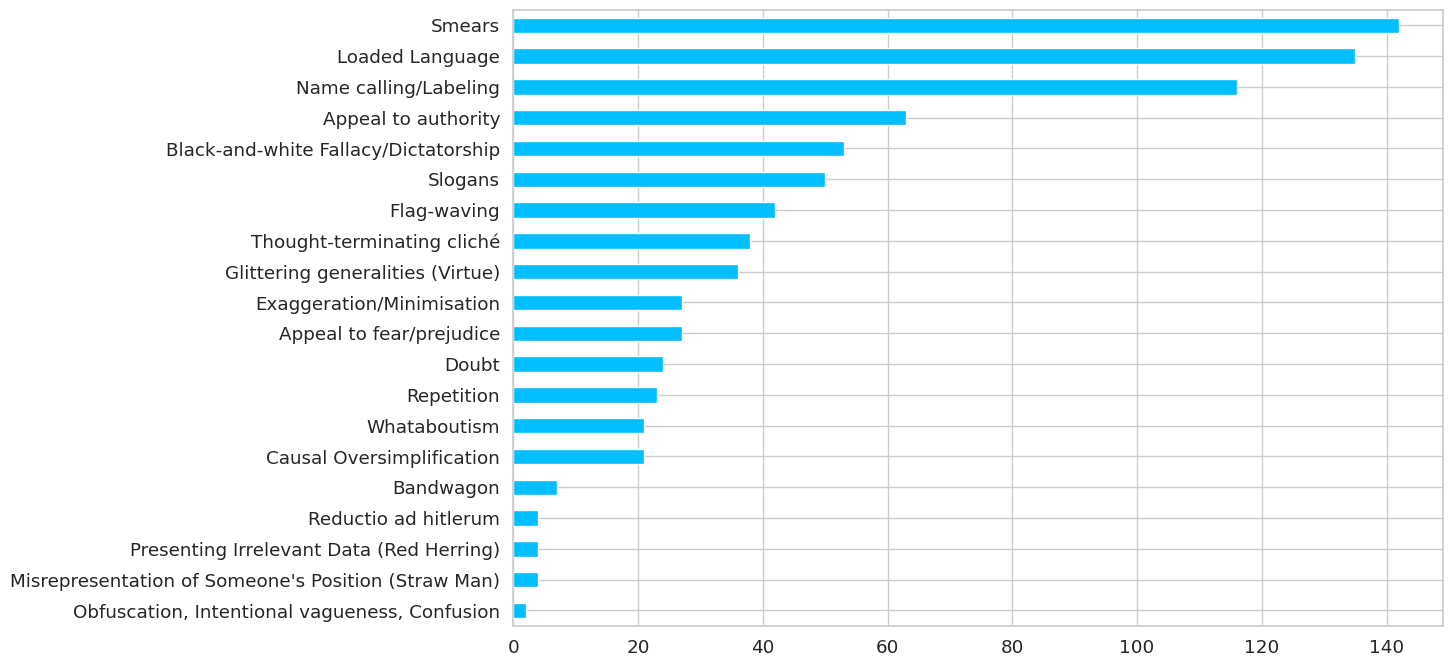

In [29]:
df_val[column_names].sum().sort_values().plot(kind='barh')

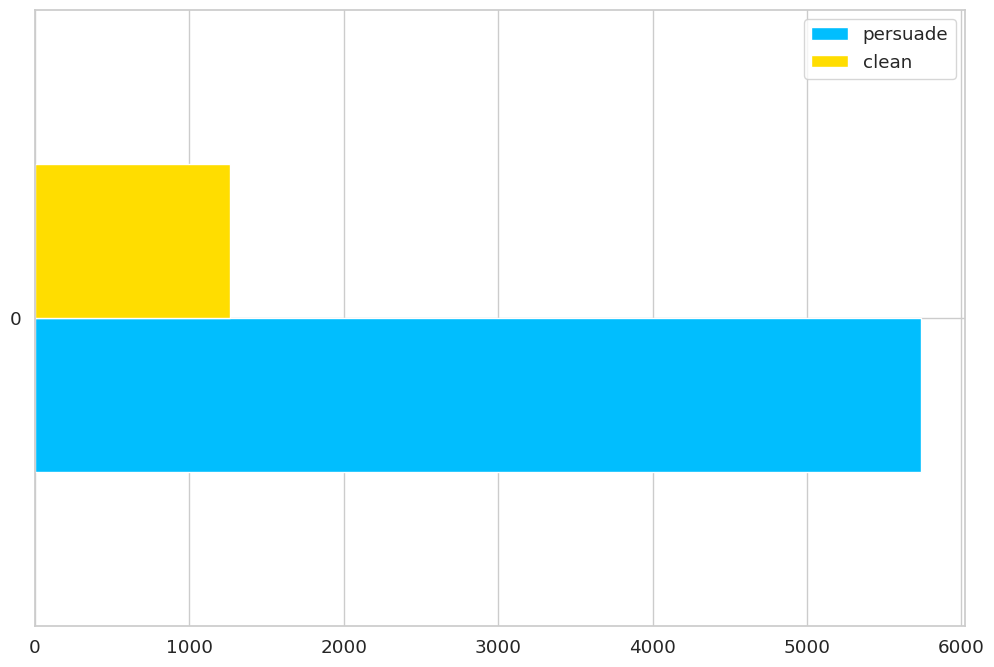

In [30]:
train_persuade = df_train[df_train[column_names].sum(axis=1) > 0]
train_clean = df_train[df_train[column_names].sum(axis=1) == 0]
pd.DataFrame(dict(
  persuade=[len(train_persuade)],
  clean=[len(train_clean)]
)).plot(kind='barh');

In [31]:
train_persuade.shape, train_clean.shape

((5736, 24), (1264, 24))

### Sample testing

In [32]:
df_train = df_train.drop(columns=['id','labels','link'],axis=1)
df_val = df_val.drop(columns=['id','labels','link'])

df_train.shape, df_val.shape

((7000, 21), (500, 21))

In [33]:
CLASS_NAMES

{'Appeal to authority',
 'Appeal to fear/prejudice',
 'Bandwagon',
 'Black-and-white Fallacy/Dictatorship',
 'Causal Oversimplification',
 'Doubt',
 'Exaggeration/Minimisation',
 'Flag-waving',
 'Glittering generalities (Virtue)',
 'Loaded Language',
 "Misrepresentation of Someone's Position (Straw Man)",
 'Name calling/Labeling',
 'Obfuscation, Intentional vagueness, Confusion',
 'Presenting Irrelevant Data (Red Herring)',
 'Reductio ad hitlerum',
 'Repetition',
 'Slogans',
 'Smears',
 'Thought-terminating cliché',
 'Whataboutism'}

In [34]:
LABEL_COLUMNS = list(CLASS_NAMES)
sample_row = df_train.iloc[16]
sample_text = sample_row.text
sample_label = sample_row[LABEL_COLUMNS]

print(sample_text,end='\n\n')
print(sample_label.to_dict())

ME VOTING ANTI-TRUMP IN 2016\n\nME VOTING ANTI-TRUMP IN 2020

{'Appeal to fear/prejudice': 0, 'Black-and-white Fallacy/Dictatorship': 0, 'Repetition': 1, 'Thought-terminating cliché': 0, 'Loaded Language': 0, 'Presenting Irrelevant Data (Red Herring)': 0, 'Exaggeration/Minimisation': 0, 'Appeal to authority': 0, 'Bandwagon': 0, 'Obfuscation, Intentional vagueness, Confusion': 0, 'Whataboutism': 0, 'Smears': 0, 'Reductio ad hitlerum': 0, 'Doubt': 0, 'Slogans': 0, "Misrepresentation of Someone's Position (Straw Man)": 0, 'Glittering generalities (Virtue)': 0, 'Causal Oversimplification': 0, 'Flag-waving': 0, 'Name calling/Labeling': 0}


In [35]:
LABEL_COLUMNS, len(LABEL_COLUMNS)

(['Appeal to fear/prejudice',
  'Black-and-white Fallacy/Dictatorship',
  'Repetition',
  'Thought-terminating cliché',
  'Loaded Language',
  'Presenting Irrelevant Data (Red Herring)',
  'Exaggeration/Minimisation',
  'Appeal to authority',
  'Bandwagon',
  'Obfuscation, Intentional vagueness, Confusion',
  'Whataboutism',
  'Smears',
  'Reductio ad hitlerum',
  'Doubt',
  'Slogans',
  "Misrepresentation of Someone's Position (Straw Man)",
  'Glittering generalities (Virtue)',
  'Causal Oversimplification',
  'Flag-waving',
  'Name calling/Labeling'],
 20)

In [36]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
tokenizer

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [37]:
encoding = tokenizer.encode_plus(sample_text,
                      add_special_tokens=True,
                      max_length=512,
                      return_token_type_ids=False,
                      padding='max_length',
                      return_attention_mask=True,
                      return_tensors='pt')
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [38]:
encoding['input_ids'].shape, encoding['attention_mask'].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [39]:
encoding['input_ids'].squeeze()[:40]

tensor([  101, 22157,   159, 14697, 15740, 23096, 21669,   118,   157,  2069,
        25810,  2101, 15969,  1446,   165,   183,   165,   183, 14424,   159,
        14697, 15740, 23096, 21669,   118,   157,  2069, 25810,  2101, 15969,
        12795,   102,     0,     0,     0,     0,     0,     0,     0,     0])

In [40]:
encoding['attention_mask'].squeeze()[:40]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [41]:
encoding['input_ids'].squeeze().shape

torch.Size([512])

In [42]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'].squeeze())[:20])

['[CLS]', 'ME', 'V', '##OT', '##ING', 'AN', '##TI', '-', 'T', '##R', '##UM', '##P', 'IN', '2016', '\\', 'n', '\\', 'n', '##ME', 'V']


(0.0, 512.0)

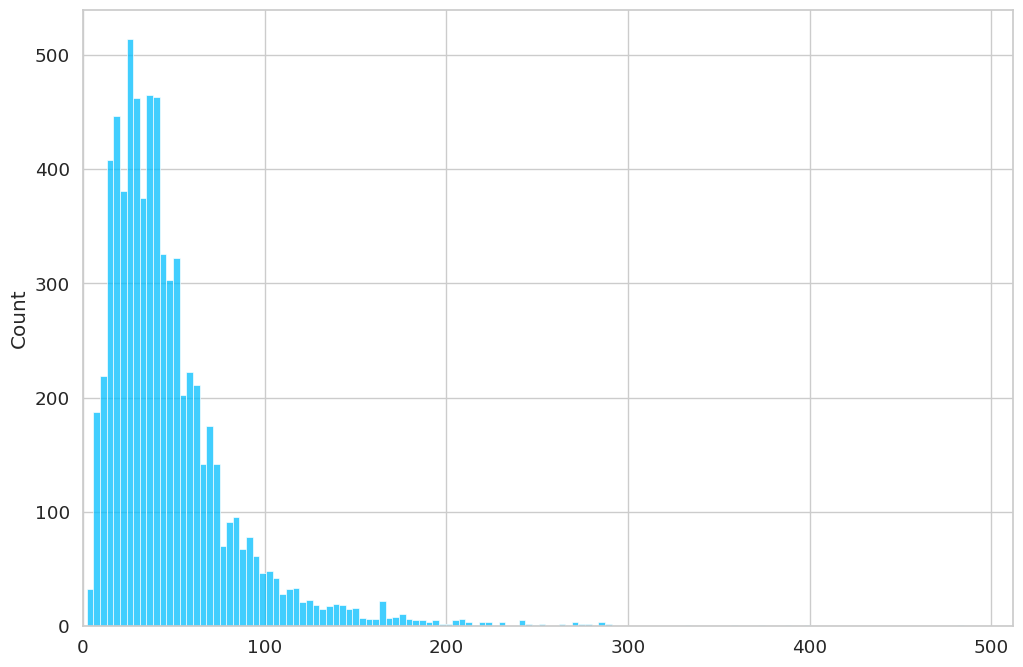

In [43]:
token_counts = []

for _, row in df_train.iterrows():
    token_count = len(tokenizer.encode(
        row['text'],
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)

sns.histplot(token_counts)
plt.xlim([0,512])

In [44]:
MAX_TOKEN_COUNT = 256

### Special Tokens

In [45]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [46]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [47]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [48]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

### Creating the Dataset & Loading the model

In [49]:
class PersuasionDataset(Dataset):
    def __init__(self,
                 data: pd.DataFrame,
                 tokenizer: BertTokenizer,
                 max_token_len: int = 128):
        self.data=data
        self.tokenizer=tokenizer
        self.max_token_len=max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        meme_text = data_row.text
        labels = data_row[LABEL_COLUMNS]

        encoding = self.tokenizer.encode_plus(
            meme_text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return dict(
            meme_text=meme_text,
            input_ids=encoding['input_ids'].flatten(),
            attention_mask=encoding['attention_mask'].flatten(),
            labels=torch.FloatTensor(labels)
        )

In [50]:
train_dataset = PersuasionDataset(df_train,tokenizer,MAX_TOKEN_COUNT)
train_dataset

In [51]:
sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['meme_text', 'input_ids', 'attention_mask', 'labels'])

In [52]:
sample_item['meme_text']

'THIS IS WHY YOU NEED\\n\\nA SHARPIE WITH YOU AT ALL TIMES'

In [53]:
sample_item['labels'], sample_item['labels'].shape

(tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 torch.Size([20]))

In [54]:
sample_item['input_ids'].shape

torch.Size([256])

In [55]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME,return_dict=True)
bert_model

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [56]:
sample_item['input_ids'].unsqueeze(dim=0).shape

torch.Size([1, 256])

In [57]:
prediction = bert_model(sample_item['input_ids'].unsqueeze(dim=0),
                        sample_item['attention_mask'].unsqueeze(dim=0))

prediction.last_hidden_state.shape, prediction.pooler_output.shape

(torch.Size([1, 256, 768]), torch.Size([1, 768]))

In [58]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8)))

sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 256]), torch.Size([8, 256]))

In [59]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 256, 768]), torch.Size([8, 768]))

### Creating the Data Module

In [60]:
class PersuasionDataModule(pl.LightningDataModule):
    def __init__(self,train_df,test_df,tokenizer,batch_size=8,max_token_len=128):
        super().__init__()
        self.train_df=train_df
        self.test_df=test_df
        self.tokenizer=tokenizer
        self.batch_size=batch_size
        self.max_token_len=max_token_len

    def setup(self,stage=None):
        self.train_dataset = PersuasionDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )

        self.test_dataset = PersuasionDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
        )

In [61]:
EPOCHS = 6
BATCH_SIZE = 12

data_module = PersuasionDataModule(df_train,df_val,tokenizer,BATCH_SIZE,MAX_TOKEN_COUNT)
data_module

In [62]:
class PersuasionTechniqueDetector(pl.LightningModule):
    def __init__(self,n_classes: int,n_training_steps=None,n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME,return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size,n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()
        self.outputs = []

    def forward(self,input_ids,attention_mask,labels=None):
        output = self.bert(input_ids,attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        loss = 0

        if labels is not None:
            loss = self.criterion(output,labels)

        return loss, output

    def training_step(self,batch):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        loss, output = self(input_ids,attention_mask,labels)
        self.log('train_loss',loss,prog_bar=True,logger=True)
        output_dict = {
            'loss': loss,
            'predictions': output,
            'labels': labels
        }
        self.outputs.append(output_dict)

        return output_dict

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)

        return loss

    def test_step(self,batch):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        loss, output = self(input_ids,attention_mask,labels)
        self.log('test_loss',loss,prog_bar=True,logger=True)

        return loss

    def on_train_epoch_end(self):
        labels = []
        predictions = []

        for output in self.outputs:
            for out_labels in output['labels'].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output['predictions'].detach().cpu():
                predictions.append(out_predictions)
        self.outputs.clear()

        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)

        for i, name in enumerate(LABEL_COLUMNS):
            class_roc_auc = auroc(predictions[:,i].unsqueeze(dim=0),labels[:,i].unsqueeze(dim=0),task='multilabel',num_labels=7000)
            self.logger.experiment.add_scalar(f'{name}_roc_auc/Train',class_roc_auc,self.current_epoch)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(),lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step'
            }
        }

### Optimizer Scheduler

In [63]:
test_model = nn.Linear(in_features=2,out_features=1)
optimizer = torch.optim.AdamW(params=test_model.parameters(),lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
    optimizer.step()
    scheduler.step()
    learning_rate_history.append(optimizer.param_groups[0]['lr'])

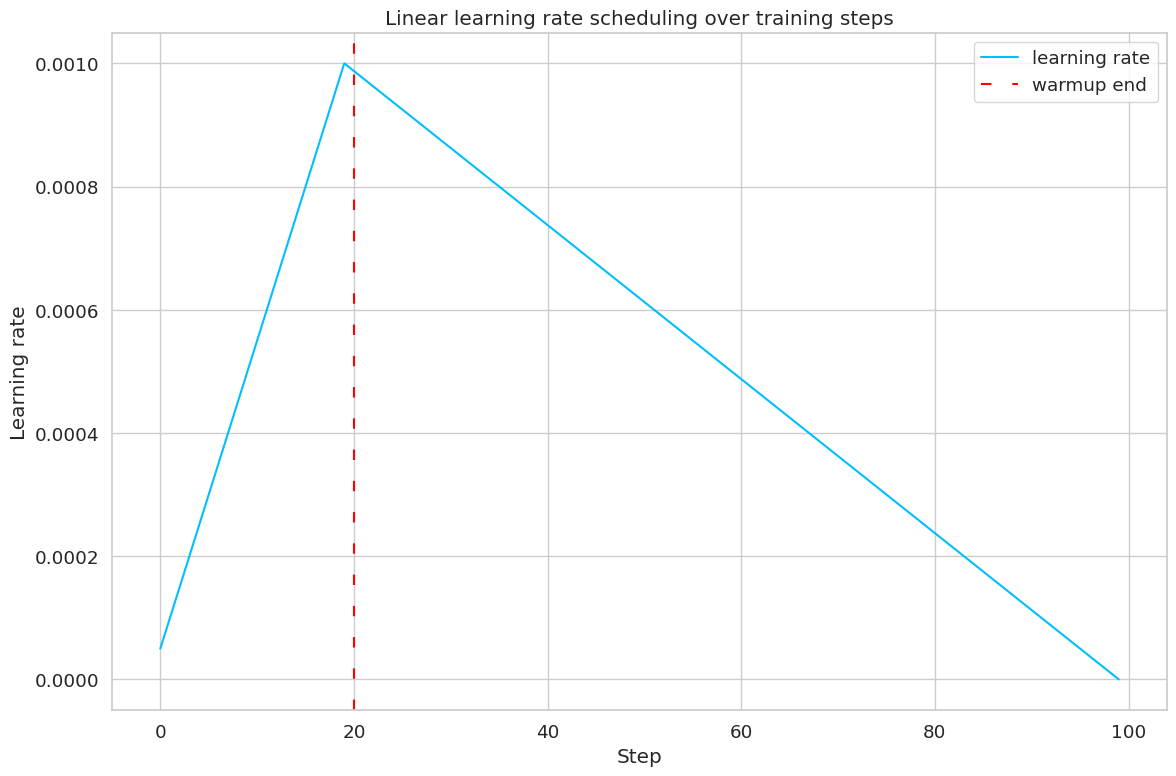

In [64]:
plt.plot(learning_rate_history,label='learning rate')
plt.axvline(x=warmup_steps,color='red',linestyle=(0,(5,10)),label='warmup end')
plt.legend()
plt.title('Linear learning rate scheduling over training steps')
plt.xlabel('Step')
plt.ylabel('Learning rate')
plt.tight_layout();

In [65]:
steps_per_epoch = len(df_train) // BATCH_SIZE
total_training_steps = steps_per_epoch * EPOCHS
warmup_steps = total_training_steps // 5

steps_per_epoch, total_training_steps, warmup_steps

(583, 3498, 699)

In [66]:
model = PersuasionTechniqueDetector(
    n_classes=len(CLASS_NAMES),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)

model

PersuasionTechniqueDetector(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

### Base Model Evaluation

In [67]:
loss = nn.BCELoss()

prediction = torch.FloatTensor(
    [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)

labels = torch.FloatTensor(
    [1., 0., 0., 0., 1., 0.]
)

In [68]:
torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

In [69]:
loss(torch.sigmoid(prediction),labels)

tensor(0.8725)

In [70]:
_, predictions = model(sample_item['input_ids'].unsqueeze(dim=0),sample_item['attention_mask'].unsqueeze(dim=0))
predictions

tensor([[0.5879, 0.5310, 0.3373, 0.3636, 0.4765, 0.5249, 0.3815, 0.4279, 0.4434,
         0.3955, 0.4073, 0.3474, 0.6267, 0.6475, 0.5154, 0.5347, 0.5916, 0.3416,
         0.5342, 0.5014]], grad_fn=<SigmoidBackward0>)

In [71]:
loss(predictions,sample_item['labels'].unsqueeze(dim=0))

tensor(0.6572, grad_fn=<BinaryCrossEntropyBackward0>)

### ROC Curve

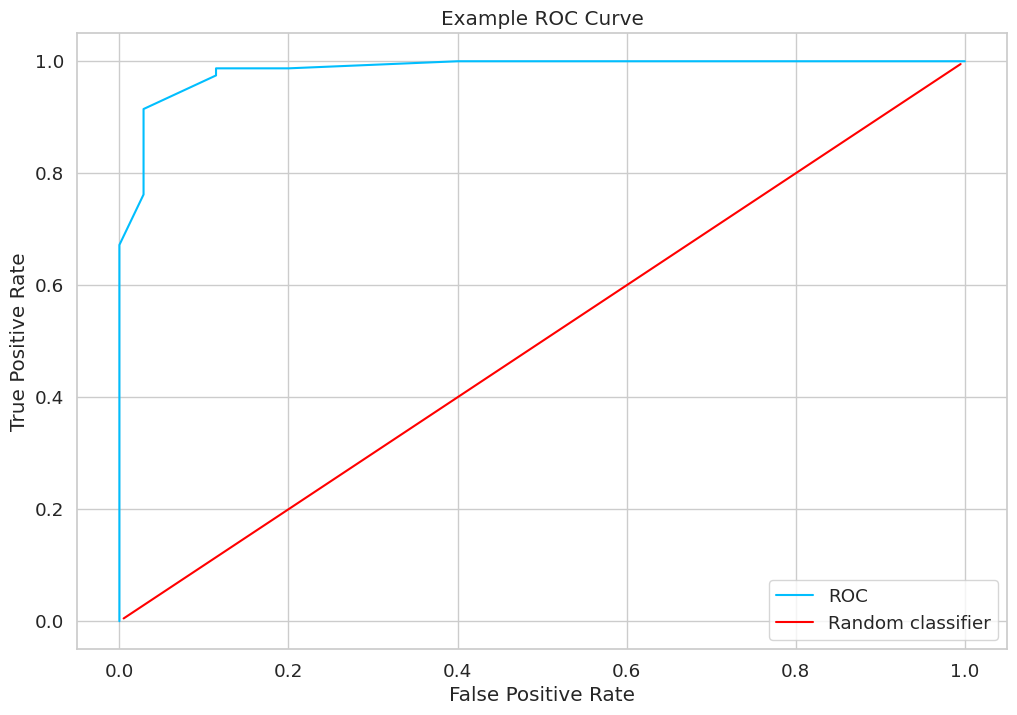

In [72]:
fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]

tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]

_, ax = plt.subplots()
ax.plot(fpr,tpr,label='ROC')
ax.plot([0.05,0.95],[0.05,0.95],transform=ax.transAxes,label='Random classifier',color='red')
ax.legend(loc=4)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Example ROC Curve')
plt.show();

### Training the model

In [73]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

In [74]:
logger = TensorBoardLogger('lightning_logs',name='persuasion_techniques')

In [75]:
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=2)

In [76]:
trainer = pl.Trainer(
    logger=logger,
    callbacks=[early_stopping_callback,checkpoint_callback],
    max_epochs=EPOCHS,
    devices='auto',
    accelerator='auto',
    enable_progress_bar=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [77]:
trainer.fit(model,data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 15.4 K
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.303   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 584: 'val_loss' reached 0.24399 (best 0.24399), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1168: 'val_loss' reached 0.23108 (best 0.23108), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1752: 'val_loss' reached 0.22336 (best 0.22336), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 2336: 'val_loss' reached 0.21629 (best 0.21629), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 2920: 'val_loss' reached 0.21489 (best 0.21489), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 3504: 'val_loss' reached 0.21456 (best 0.21456), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=6` reached.


In [78]:
import pickle

with open('bert_model_v2.pkl', 'wb') as f:
    pickle.dump(model, f)
print('model saved')

model saved


In [79]:
import pickle

trained_model = PersuasionTechniqueDetector(
    n_classes=len(CLASS_NAMES),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)
print('Loading model parameters...')
with open('bert_model_v2.pkl','rb') as f:
    trained_model = pickle.load(f)
print('Loaded successfully!')

Loading model parameters...
Loaded successfully!


In [80]:
trained_model.eval()
trained_model.freeze()

In [81]:
test_meme_text = "WE WILL LEAVE THE COUNTRY IF TRUMP IS ELECTED\\n\\nPLEASE LIKE AND SHARE TO SUPPORT THEIR PLAN!"

encoding = tokenizer.encode_plus(
    test_meme_text,
    add_special_tokens=True,
    max_length=MAX_TOKEN_COUNT,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
)

_, test_prediction = trained_model(encoding['input_ids'],encoding['attention_mask'])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(CLASS_NAMES, test_prediction):
  print(f"{label}: {prediction}")

Appeal to fear/prejudice: 0.052660781890153885
Black-and-white Fallacy/Dictatorship: 0.1738283485174179
Repetition: 0.044081397354602814
Thought-terminating cliché: 0.04250575229525566
Loaded Language: 0.07060567289590836
Presenting Irrelevant Data (Red Herring): 0.026806849986314774
Exaggeration/Minimisation: 0.10083514451980591
Appeal to authority: 0.016579169780015945
Bandwagon: 0.0717601552605629
Obfuscation, Intentional vagueness, Confusion: 0.015863804146647453
Whataboutism: 0.02664104849100113
Smears: 0.047413088381290436
Reductio ad hitlerum: 0.025008447468280792
Doubt: 0.054338742047548294
Slogans: 0.36279386281967163
Misrepresentation of Someone's Position (Straw Man): 0.024868210777640343
Glittering generalities (Virtue): 0.2534627318382263
Causal Oversimplification: 0.026769131422042847
Flag-waving: 0.6369288563728333
Name calling/Labeling: 0.10741175711154938


In [82]:
THRESHOLD = 0.04

test_meme_text = "WE WILL LEAVE THE COUNTRY IF TRUMP IS ELECTED\\n\\nPLEASE LIKE AND SHARE TO SUPPORT THEIR PLAN!"

encoding = tokenizer.encode_plus(
    test_meme_text,
    add_special_tokens=True,
    max_length=MAX_TOKEN_COUNT,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
)

_, test_prediction = trained_model(encoding['input_ids'],encoding['attention_mask'])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(CLASS_NAMES, test_prediction):
    if prediction < THRESHOLD:
        continue
    print(f"{label}: {prediction}")

Appeal to fear/prejudice: 0.052660781890153885
Black-and-white Fallacy/Dictatorship: 0.1738283485174179
Repetition: 0.044081397354602814
Thought-terminating cliché: 0.04250575229525566
Loaded Language: 0.07060567289590836
Exaggeration/Minimisation: 0.10083514451980591
Bandwagon: 0.0717601552605629
Smears: 0.047413088381290436
Doubt: 0.054338742047548294
Slogans: 0.36279386281967163
Glittering generalities (Virtue): 0.2534627318382263
Flag-waving: 0.6369288563728333
Name calling/Labeling: 0.10741175711154938


In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

predictions = []
labels = []

for item in tqdm(train_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )

  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/7000 [00:00<?, ?it/s]

In [88]:
accuracy(predictions, labels, threshold=THRESHOLD, task='multilabel', num_labels=len(column_names))

tensor(0.6088)

In [83]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
val_dataset = PersuasionDataset(
  df_val,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )

  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/500 [00:00<?, ?it/s]

In [84]:
accuracy(predictions, labels, threshold=THRESHOLD, task='multilabel', num_labels=len(column_names))

tensor(0.6212)

In [85]:
from sklearn.metrics import classification_report

y_pred = predictions.numpy()
y_true = labels.numpy()
upper, lower = 1, 0
y_pred = np.where(y_pred > THRESHOLD, upper, lower)
print(classification_report(
  y_true,
  y_pred,
  target_names=LABEL_COLUMNS,
  zero_division=0
))

                                                     precision    recall  f1-score   support

                           Appeal to fear/prejudice       0.07      0.67      0.13        27
               Black-and-white Fallacy/Dictatorship       0.13      0.96      0.23        53
                                         Repetition       0.14      0.78      0.24        23
                         Thought-terminating cliché       0.11      0.95      0.20        38
                                    Loaded Language       0.28      0.99      0.44       135
           Presenting Irrelevant Data (Red Herring)       0.00      0.00      0.00         4
                          Exaggeration/Minimisation       0.09      0.89      0.16        27
                                Appeal to authority       0.48      0.92      0.63        63
                                          Bandwagon       0.11      0.43      0.18         7
      Obfuscation, Intentional vagueness, Confusion       0.00      0